In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
df_train = pd.read_csv("../input/train.csv")
df_test = pd.read_csv("../input/test.csv")
print(df_train.shape)
print(df_test.shape)

(15035, 21)
(6468, 20)


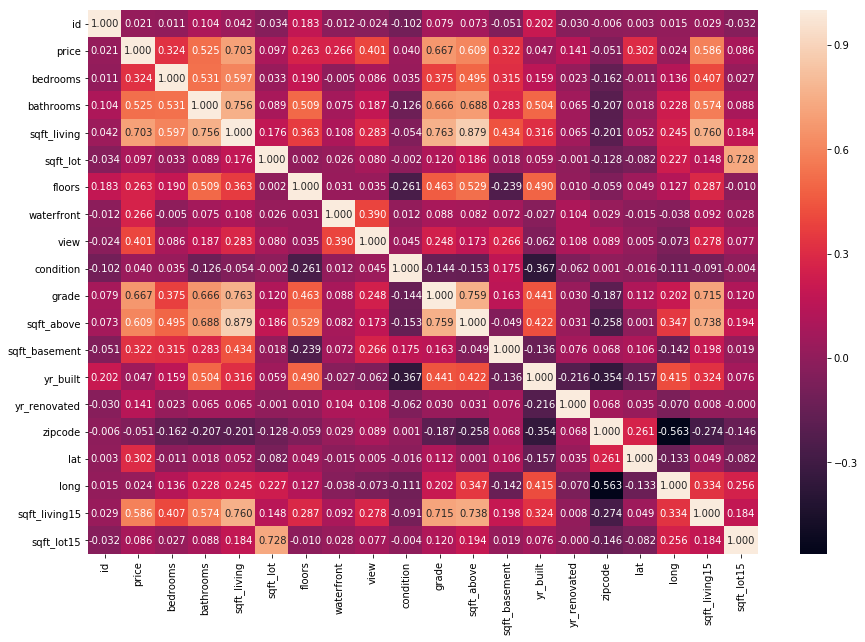

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_train.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, annot=True, fmt=".3f")
plt.show()

In [4]:
df_train.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [5]:
df_test.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

## 데이터를 나누기

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
# sel = ['sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms']
# y = df_train['price']  # 예측하려고 하는 값(집가격)
# X = df_train[sel]      # 예측할 때, 모델을 학습시킬 때 사용하는 데이터
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=123)  

In [8]:
y = df_train['price']  
X = df_train.drop('price', axis=1)  # 집가격을 뺀 변수컬럼을 X로 한다.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                            test_size=0.20, random_state=123) 

In [9]:
for df in [df_train,df_test]:
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)  # 주택 개조 연도
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])                    # 주택 개조 연도가 없다면 건축 연도로 채운다.

In [10]:
for df in [df_train,df_test]:
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']    # 침실과 욕실의 총합.
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']   # 실제 주거 공간 + 토지 전체 공간
    df['sqft_total_size'] = df['sqft_living'] + df['sqft_lot'] + df['sqft_above'] + df['sqft_basement']  # 지하실 제외 집의 평방 피트, 집 지하실 포함.
    df['sqft_total15'] = df['sqft_living15'] + df['sqft_lot15']  # 2015년 거실, 2015년 lotSize영역 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']    
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    
    df['sqft_total_by_lot'] = (df['sqft_living'] + df['sqft_above'] + df['sqft_basement'])/df['sqft_lot']
    
    qcut_count = 10
    df['qcut_long'] = pd.qcut(df['long'], qcut_count, labels=range(qcut_count))
    df['qcut_lat'] = pd.qcut(df['lat'], qcut_count, labels=range(qcut_count))
    df['qcut_long'] = df['qcut_long'].astype(int)
    df['qcut_lat'] = df['qcut_lat'].astype(int)
    
    #df['date_year'] = df['date'].dt.year
    #df['date_month'] = df['date'].dt.month
    #df['date_day'] = df['date'].dt.day

In [11]:
df_train['per_price'] = df_train['price']/df_train['sqft_total_size']
zipcode_price = df_train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
df_train = pd.merge(df_train,zipcode_price,how='left',on='zipcode')
df_test = pd.merge(df_test,zipcode_price,how='left',on='zipcode')
del df_train['per_price']

In [12]:
y = df_train['price']  
X = df_train.drop('price', axis=1)  # 집가격을 뺀 변수컬럼을 X로 한다.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                            test_size=0.20, random_state=123)

In [13]:
X_train = X_train.drop('date', axis=1) 
X_valid = X_valid.drop('date', axis=1) 

In [14]:
print(X_train.shape)   # 학습용 문제
print(X_valid.shape)   # 평가용 문제(실전 모의고사)
print(y_train.shape)   # 학습용 답
print(y_valid.shape)   # 평가용 답(실전 모의고사)

(12028, 29)
(3007, 29)
(12028,)
(3007,)


In [15]:
print(X_train.columns)

Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'total_rooms', 'sqft_ratio',
       'sqft_total_size', 'sqft_total15', 'is_renovated', 'sqft_total_by_lot',
       'qcut_long', 'qcut_lat', 'mean', 'var'],
      dtype='object')


In [18]:
from sklearn import linear_model
model = linear_model.LinearRegression()  # 사용할 모델 선택 
model.fit(X_train, y_train)              # 학습용 문제와 답을 이용하여 공부(학습)시키기
y_pred_linear = model.predict(X_valid)   # 학습한 모델(똑똑해진?)친구로 실전모의고사 데이터로 집값 예측

In [19]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

In [20]:
## xgbm
# kernel에는 기본적으로 lightgbm, xgboost가 설치되어 있다.
import lightgbm as lgb
from xgboost import XGBRegressor

In [21]:
## lgbm
lightgbm = lgb.LGBMRegressor(random_state=123)
lightgbm.fit(X_train, y_train)
y_pred_lgbm = lightgbm.predict(X_valid)

In [22]:
## xgbm
xgbm_model = XGBRegressor()
xgbm_model.fit(X_train, y_train)
y_pred_xgbm = xgbm_model.predict(X_valid)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [23]:
y_pred_knn = neigh.predict(X_valid)
y_pred_knn.shape

(3007,)

In [24]:
from sklearn.metrics import mean_squared_error        # 실제값과 예측값의 차이에 대한 평가 지표를 계산해줌.
print("Mean Squared Error(linear regression) : " + str(mean_squared_error(y_pred_linear, y_valid)))
score = np.sqrt(mean_squared_error(y_pred_linear, y_valid))
print("RMSE_linear : " + str(score))
score = np.sqrt(mean_squared_error(y_pred_knn, y_valid))
print("RMSE_knn : " + str(score))
score = np.sqrt(mean_squared_error(y_pred_lgbm, y_valid))
print("RMSE_lgbm : " + str(score))
score = np.sqrt(mean_squared_error(y_pred_xgbm, y_valid))
print("RMSE_xgbm : " + str(score))

Mean Squared Error(linear regression) : 39981966443.231445
RMSE_linear : 199954.91102553956
RMSE_knn : 292427.14568723715
RMSE_lgbm : 138262.03621430421
RMSE_xgbm : 127250.67408827749


In [25]:
X_test = df_test.drop('date', axis=1)   # 실전 데이터 이용 
y_pred_lgbm = lightgbm.predict(X_test)  # 예측

In [26]:
sub = pd.read_csv("../input/sample_submission.csv")
sub['price'] = y_pred_lgbm
sub.to_csv("mySolution_lgbm.csv", index=False)

In [27]:
sel = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'view', 'condition', 'grade', 'yr_built', 'long', 'sqft_living15', 'sqft_lot15']
sel

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'view',
 'condition',
 'grade',
 'yr_built',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [28]:
train_problem = df_train[sel] # 전체 데이터 중에 4개의 컬럼(변수)를 일부 선택
solution = df_train['price']
real_problem = df_test[sel]

In [29]:
print(train_problem.shape) # 학습시킬 문제수
print(solution.shape)  # 학습시킬 정답
print(real_problem.shape)  # 실전문제 문제수

(15035, 11)
(15035,)
(6468, 11)


In [30]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [31]:
# 로봇 만들기
model = linear_model.LinearRegression()
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [32]:
model.fit(train_problem, solution)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [33]:
real_sol = model.predict(real_problem)

In [34]:
sub = pd.read_csv("../input/sample_submission.csv")
print(sub.columns, sub.shape)
sub.head()

Index(['id', 'price'], dtype='object') (6468, 2)


,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [35]:
sub['price'] = real_sol # 답(집의 가격) 제출 파일에 넣어줌.
sub.to_csv("mySolution.csv", index=False) # index 없애주어 답지 형태로 변환